{/* cspell:ignore mcscf chmax Dmax vmax ecore ncas Excp disp */}

# Determining a molecular geometry

In the previous section, we implemented VQE to determine the ground state energy of a molecule. That is a valid use of quantum computing, but even more useful would be to determine the structure of a molecule.

## Step 1: Map classical inputs to a quantum problem

Remaining with our basic example of diatomic hydrogen, the only geometric parameter to vary is the bond length. To accomplish this, we proceed as before, but using a variable in our initial molecule construction (a bond length, *x*, in the argument). This is a fairly simple change, but it does require that the variable be included in functions throughout the process, since it starts in the fermionic Hamiltonian construction and propagates through the mapping and finally to the cost function.

First, we load some of the packages we used before and define the Cholesky function.



In [1]:
# LINUX ONLY
from qiskit.quantum_info import SparsePauliOp
import matplotlib.pyplot as plt
import numpy as np

#!pip install pyscf==2.4.0
from pyscf import ao2mo, gto, mcscf, scf


def cholesky(V, eps):
    # see https://arxiv.org/pdf/1711.02242.pdf section B2
    # see https://arxiv.org/abs/1808.02625
    # see https://arxiv.org/abs/2104.08957
    no = V.shape[0]
    chmax, ng = 20 * no, 0
    W = V.reshape(no**2, no**2)
    L = np.zeros((no**2, chmax))
    Dmax = np.diagonal(W).copy()
    nu_max = np.argmax(Dmax)
    vmax = Dmax[nu_max]
    while vmax > eps:
        L[:, ng] = W[:, nu_max]
        if ng > 0:
            L[:, ng] -= np.dot(L[:, 0:ng], (L.T)[0:ng, nu_max])
        L[:, ng] /= np.sqrt(vmax)
        Dmax[: no**2] -= L[: no**2, ng] ** 2
        ng += 1
        nu_max = np.argmax(Dmax)
        vmax = Dmax[nu_max]
    L = L[:, :ng].reshape((no, no, ng))
    print(
        "accuracy of Cholesky decomposition ",
        np.abs(np.einsum("prg,qsg->prqs", L, L) - V).max(),
    )
    return L, ng


def identity(n):
    return SparsePauliOp.from_list([("I" * n, 1)])


def creators_destructors(n, mapping="jordan_wigner"):
    c_list = []
    if mapping == "jordan_wigner":
        for p in range(n):
            if p == 0:
                ell, r = "I" * (n - 1), ""
            elif p == n - 1:
                ell, r = "", "Z" * (n - 1)
            else:
                ell, r = "I" * (n - p - 1), "Z" * p
            cp = SparsePauliOp.from_list([(ell + "X" + r, 0.5), (ell + "Y" + r, -0.5j)])
            c_list.append(cp)
    else:
        raise ValueError("Unsupported mapping.")
    d_list = [cp.adjoint() for cp in c_list]
    return c_list, d_list

Now to define our Hamiltonian, we will use PySCF exactly as in the previous example, but now we will include a variable, `x`, to play the role of our interatomic distance. This will return the core energy, single-electron energy, and two-electron energies as before.



In [2]:
def ham_terms(x: float):
    distance = x
    a = distance / 2
    mol = gto.Mole()
    mol.build(
        verbose=0,
        atom=[
            ["H", (0, 0, -a)],
            ["H", (0, 0, a)],
        ],
        basis="sto-6g",
        spin=0,
        charge=0,
        symmetry="Dooh",
    )

    # mf = scf.RHF(mol)
    # mx = mcscf.CASCI(mf, ncas=2, nelecas=(1, 1))
    # mx.kernel()

    mf = scf.RHF(mol)
    mf.kernel()
    if not mf.converged:
        raise RuntimeError(f"SCF did not converge for distance {x}")

    mx = mcscf.CASCI(mf, ncas=2, nelecas=(1, 1))
    casci_energy = mx.kernel()
    if casci_energy is None:
        raise RuntimeError(f"CASCI failed for distance {x}")

    # Other variables that might come in handy:
    # active_space = range(mol.nelectron // 2 - 1, mol.nelectron // 2 + 1)
    #    E1 = mf.kernel()
    # mo = mx.sort_mo(active_space, base=0)
    #    E2 = mx.kernel(mo)[:2]

    h1e, ecore = mx.get_h1eff()
    h2e = ao2mo.restore(1, mx.get_h2eff(), mx.ncas)
    return ecore, h1e, h2e

Recall that the construction above is making a fermionic Hamiltonian based on the atomic species, geometry, and electronic orbitals. Below, we map this fermionic Hamiltonian onto Pauli operators. This `build_hamiltonian` function will also include a geometric variable as an argument.



In [3]:
def build_hamiltonian(distx: float) -> SparsePauliOp:
    ecore = ham_terms(distx)[0]
    h1e = ham_terms(distx)[1]
    h2e = ham_terms(distx)[2]

    ncas, _ = h1e.shape

    C, D = creators_destructors(2 * ncas, mapping="jordan_wigner")
    Exc = []
    for p in range(ncas):
        Excp = [C[p] @ D[p] + C[ncas + p] @ D[ncas + p]]
        for r in range(p + 1, ncas):
            Excp.append(
                C[p] @ D[r]
                + C[ncas + p] @ D[ncas + r]
                + C[r] @ D[p]
                + C[ncas + r] @ D[ncas + p]
            )
        Exc.append(Excp)

    # low-rank decomposition of the Hamiltonian
    Lop, ng = cholesky(h2e, 1e-6)
    t1e = h1e - 0.5 * np.einsum("pxxr->pr", h2e)

    H = ecore * identity(2 * ncas)
    # one-body term
    for p in range(ncas):
        for r in range(p, ncas):
            H += t1e[p, r] * Exc[p][r - p]
    # two-body term
    for g in range(ng):
        Lg = 0 * identity(2 * ncas)
        for p in range(ncas):
            for r in range(p, ncas):
                Lg += Lop[p, r, g] * Exc[p][r - p]
        H += 0.5 * Lg @ Lg

    return H.chop().simplify()

We will load the remaining packages for running VQE itself, such as the efficient\_su2 ansatz, and SciPy minimizers:



In [4]:
# General imports

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import efficient_su2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions

# ### REAL computing
# # Qiskit Runtime tools
# from qiskit_ibm_runtime import QiskitRuntimeService
# service = QiskitRuntimeService()




We will again define the cost function, but this always took a fully-built and mapped Hamiltonian as an argument, so nothing changes about this function.



In [5]:
def cost_func(params, ansatz, H, estimator):
    pub = (ansatz, [H], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]
    return energy


# def cost_func_sim(params, ansatz, H, estimator):
#    energy = estimator.run(ansatz, H, parameter_values=params).result().values[0]
#    return energy

## Step 2: Optimize problem for quantum execution

Because the Hamiltonian will change with each new geometry, the transpiling of the operator will change at each step. We can nevertheless define a general pass manager to be applied at each step, specific to the hardware we want to use.

Here we will use the least busy backend available. We will use that backend as a model for our AerSimulator, allowing our simulator to mimic, for example, the noise behavior of the real backend. These noise models are not perfect, but they may help you know what to expect from real hardware.



In [6]:
# ### REAL computing
# # Here, we select the least busy backend available:
# backend = service.least_busy(operational=True, simulator=False)
# print(backend)
# # Or to select a specific real backend use the line below, and substitute 'ibm_strasbourg' for your chosen device.
# # backend = service.get_backend('ibm_strasbourg')

In [26]:
# To run on a simulator:
# -----------
# from qiskit_aer import AerSimulator
import qiskit_aer

backend_sim = qiskit_aer.Aer.get_backend('qasm_simulator')
# backend = backend_sim
# backend_sim = AerSimulator.from_backend(backend)  #doesnt make sense


### USING fake simulator, it simulates pm.scheduling
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
backend_real = FakeManilaV2()

We import the pass manager and related packages to help us optimize our circuit. This step, and the one above it, are independent of the Hamiltonian, and so are unchanged from the previous lesson.



In [27]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passes import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
    ConstrainedReschedule,
)
from qiskit.circuit.library import XGate

target = backend_real.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        ConstrainedReschedule(
            acquire_alignment=target.acquire_alignment,
            pulse_alignment=target.pulse_alignment,
            target=target,
        ),
        PadDynamicalDecoupling(
            target=target,
            dd_sequence=[XGate(), XGate()],
            pulse_alignment=target.pulse_alignment,
        ),
    ]
)

## Step 3: Execute using Qiskit primitives.

In the code block below, we set up an array to store our outputs from each step in our interatomic distance $x$. We have chosen the range of $x$ based on our knowledge of the experimental value for the equilibrium bond length: 0.74 Angstrom. We will run this first on a simulator, and will thus be importing our estimator (BackendEstimator) from `qiskit.primitives`. For each geometry step, we build the Hamiltonian and allow a certain number of optimization steps (here 500) using the optimizer "cobyla". At each geometry step, we store both the total energy and the electronic energy. BECAUSE OF THE HIGH NUMBER OF OPTIMIZER STEPS, THIS MAY TAKE AN HOUR OR MORE. You may wish to modify the inputs below to reduce the required time.



In [ ]:
#This took 50 s perdist
#       ~ 9 mins in total
from qiskit.primitives import BackendEstimatorV2

estimator = BackendEstimatorV2(backend=backend_sim) #this uses aer

distances_sim = np.arange(0.3, 1.3, 0.1)
vqe_energies_sim = []
vqe_elec_energies_sim = []

for dist in distances_sim:
    xx = dist       #DISTANCE SEARCHED

    # Random initial state and efficient_su2 ansatz
    H = build_hamiltonian(xx)
    ansatz = efficient_su2(H.num_qubits)
    ansatz_isa = pm.run(ansatz)
    x0 = 2 * np.pi * np.random.random(ansatz_isa.num_parameters)
    H_isa = H.apply_layout(ansatz_isa.layout)
    nuclear_repulsion = ham_terms(xx)[0]

    n_params = ansatz_isa.num_parameters    # equal to 32

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, H_isa, estimator),
        method="cobyla",
        options={"maxiter":n_params*10, "disp": True},
    )

    # Note this returns the total energy, and we are often interested in the electronic energy
    tot_energy = getattr(res, "fun")
    electron_energy = getattr(res, "fun") - nuclear_repulsion
    print(electron_energy)
    vqe_energies_sim.append(tot_energy)
    vqe_elec_energies_sim.append(electron_energy)

    # Print all results
    print(res)

print("All energies have been calculated")

accuracy of Cholesky decomposition  5.551115123125783e-16
Return from COBYLA because the trust region radius reaches its lower bound.
Number of function values = 293   Least value of F = -0.017532217582185233
The corresponding X is:
[ 6.97834171  3.22354943  6.04916247  1.39929984  6.05851525  1.45412484
  0.15280246  6.45776233  6.43539981  1.26936351 -0.0853372   4.29796344
  8.078605    4.30937959 -0.24088809  5.40549969  4.23315929  1.58277545
  0.2337466   1.32598842  3.17058463  4.46947523  2.66509203  5.76627048
  1.68920771  4.54469567  1.05352881  1.72861467  6.72750676  0.82512963
  5.05444928  6.33440577]

-1.7814562539821854
 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -0.017532217582185233
       x: [ 6.978e+00  3.224e+00 ...  5.054e+00  6.334e+00]
    nfev: 293
   maxcv: 0.0
accuracy of Cholesky decomposition  1.5544506680540728e-16
Return from COBYLA because the objective function has been eval

The results of this output are discussed below in the post-processing section; for now, simply note that the simulation was successful. Now you are ready to run on real hardware. We will set the resilience to `1`, indicating that TREX error mitigation will be used. Now that we are working with real hardware, we will use Qiskit Runtime, and Runtime primitives. Note that both the for loop related to geometry and also the multiple variational trials are inside the session.

Because there are costs and time limits associated with real hardware runs, we have reduced the number of geometry steps and optimizer steps below. Be sure to tailor these steps according to your precision goals and time limits.



In [ ]:
# THIS TOOK 4 MINUTES (default_shots:2000 , maxiter:50 )
#           5 MINUTES (default_shots:2000 , maxiter:100)
#           9 MINUTES (default_shots:10000, maxiter:200)


from qiskit_ibm_runtime import Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import EstimatorOptions



estimator_options = EstimatorOptions(resilience_level=1, default_shots=10000)
import warnings     #suppress repeated message (because of fake backend)
warnings.filterwarnings("ignore", message=".*resilience_level option has no effect.*")

distances = np.arange(0.5, 0.9, 0.1)
vqe_energies = []
vqe_elec_energies = []


with Session(backend=backend_real) as session:
    estimator = Estimator(mode=session, options=estimator_options)

    for dist in distances:
        xx = dist

        # Random initial state and efficient_su2 ansatz

        H = build_hamiltonian(xx)
        ansatz = efficient_su2(H.num_qubits)
        ansatz_isa = pm.run(ansatz)
        H_isa = H.apply_layout(ansatz_isa.layout)
        nuclear_repulsion = ham_terms(xx)[0]
        x0 = 2 * np.pi * np.random.random(ansatz_isa.num_parameters)

        n_params = ansatz_isa.num_parameters    # equal to 32

        res = minimize(
            cost_func,
            x0,
            args=(ansatz_isa, H_isa, estimator),
            method="cobyla",
            options={"maxiter": n_params*10, "disp": True},
        )

        # Note this returns the total energy, and we are often interested in the electronic energy
        tot_energy = getattr(res, "fun")
        electron_energy = getattr(res, "fun") - nuclear_repulsion
        print(electron_energy)
        vqe_energies.append(tot_energy)
        vqe_elec_energies.append(electron_energy)

        # Print all results
        print(res)

print("All energies have been calculated")

accuracy of Cholesky decomposition  2.323732944297132e-16


## Step 4: Post-processing

For both the simulator and real hardware, we can plot the ground state energies calculated for each inter-atomic distance and see where the lowest energy is achieved. That should be the inter-atomic distance found in nature, and indeed it is close. A smoother curve might be obtained by trying other ansaetze, optimizers, and running the calculation multiple times at each geometry step and averaging over several random initial conditions.



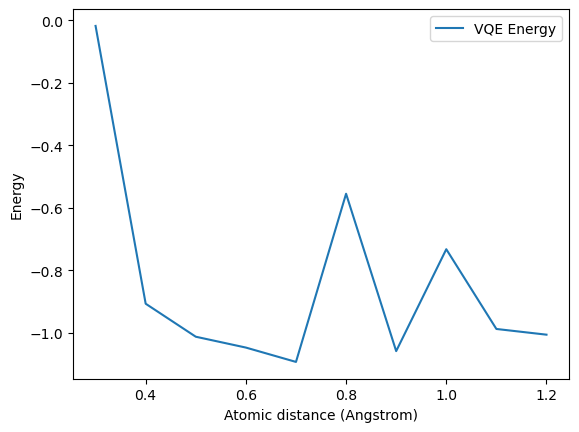

In [ ]:
# Here we can plot the results from the simulator
plt.plot(distances_sim, vqe_energies_sim, label="VQE Energy")
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.show()

Note that simply increasing the number of optimization steps is not likely to improve the results from the simulator, since all optimizations actually converged to the required tolerance in fewer than the maximum number of iterations.

The results from the real hardware are comparable, aside from a slightly different range of values sampled.



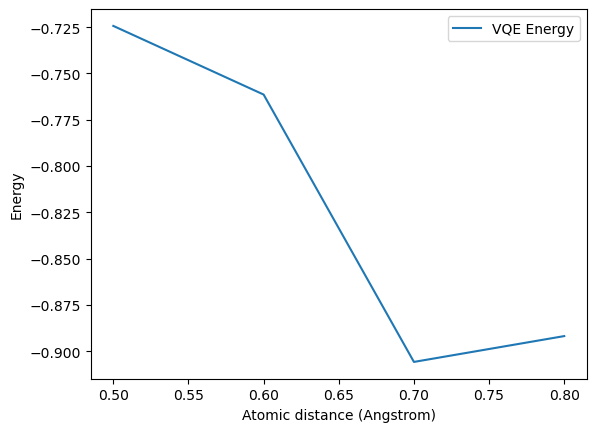

In [ ]:
#results from the fake backend with noise
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.show()

In addition to expecting an H2 bond length of 0.74 Angstrom, the total energy should be -1.17 Hartrees. We see that the real hardware results came closer to these values than the simulator. This is likely because noise was present (or simulated) in both cases, but only in the case of real hardware was error mitigation employed.

### Closing

This concludes our course on VQE for quantum chemistry. If you are interested in understanding some of the underlying information theory used in quantum computing, check out John Watrous's course on the [Basics of Quantum Information](/learning/courses/basics-of-quantum-information). For an additional short-form example of a VQE workflow, see our [Ground-state energy estimation of the Heisenberg chain with VQE tutorial](/docs/tutorials/spin-chain-vqe). Or browse the [tutorials](/docs/tutorials) and [courses](/learning) to find more educational materials about the latest technology in quantum computing.

Don't forget to take this course's exam. A score of 80% or higher will earn you a Credly badge, which will automatically be emailed to you. Thank you for being a part of the IBM Quantum® Network!



In [ ]:
import qiskit
import qiskit_ibm_runtime

print(qiskit.version.get_version_info())
print(qiskit_ibm_runtime.version.get_version_info())

2.2.1
0.43.0


© IBM Corp., 2017-2025